In [1]:
# Import my packages.
import flymovie as fm
import os
import copy
import scipy
import skimage as ski
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import dask
from time import sleep
import seaborn as sns

from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

# Activate package autoload.
%load_ext autoreload
%autoreload 2

In [2]:
datasets=[
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210910Rpb1EGFP_emb6-nc11-5.csv', '11', -38985, 24634, 852, 243),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210910Rpb1EGFP_emb6-nc11-6.csv', '11', -38985, 24870, 852, 243),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210910Rpb1EGFP_emb6-nc12-9.csv', '12', -38746, 25044, 852, 243),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210910Rpb1EGFP_emb6-nc12-10.csv', '12', -39015, 24808, 852, 243),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210910Rpb1EGFP_emb6-nc12-11.csv', '12', -38320, 24808, 852, 243)
]

In [3]:
def load_(datasets):
    def load_dataset(dataset, minvoxels=5000):
        filepath, label, x_topleft, y_topleft, xdim, ydim = dataset
        data_ = pd.read_csv(filepath)
        data_['X1, Bounding Box (Pixel)'] = data_['X1, Bounding Box (Pixel)'] - x_topleft
        data_['X2, Bounding Box (Pixel)'] = data_['X2, Bounding Box (Pixel)'] - x_topleft
        data_['Y1, Bounding Box (Pixel)'] = data_['Y1, Bounding Box (Pixel)'] - y_topleft
        data_['Y2, Bounding Box (Pixel)'] = data_['Y2, Bounding Box (Pixel)'] - y_topleft
        # Find whether bounding box touches edge of image in x-y.
        edge = (
            (data_['X1, Bounding Box (Pixel)'] == 0) |
            (data_['X2, Bounding Box (Pixel)'] == xdim) |
            (data_['Y1, Bounding Box (Pixel)'] == 0) |
            (data_['Y2, Bounding Box (Pixel)'] == ydim)
            )
        data_ = data_.loc[~edge]
        data_ = data_.loc[data_['VoxelCount, Volume'] > minvoxels]
        data_.insert(0, 'cycle', np.repeat(label, data_.shape[0]))
        cleaned_data = data_[['cycle','# Children', 'VoxelCount, Volume']]
        cleaned_data.columns = ['cycle', 'numspots', 'volume']
        return cleaned_data

    data_ = load_dataset(datasets[0])
    for dataset in datasets[1:]:
        data_ = pd.concat([data_, load_dataset(dataset)])
    return data_  

In [5]:
def load_(files):
    def load_dataset(dataset, size=(852, 243), minvoxels=5000):
        filepath, label = dataset
        data_ = pd.read_csv(filepath)
        # Find whether bounding box touches edge of image in x-y.
        edge = (
            (data_['X1, Bounding Box (Pixel)'] == 0) |
            (data_['X2, Bounding Box (Pixel)'] == size[0]) |
            (data_['Y1, Bounding Box (Pixel)'] == 0) |
            (data_['Y2, Bounding Box (Pixel)'] == size[1])
            )
        data_ = data_.loc[~edge]
        data_ = data_.loc[data_['VoxelCount, Volume'] > minvoxels]
        data_.insert(0, 'cycle', np.repeat(label, data_.shape[0]))
        filename = filepath.split('/')[-1]
        data_.insert(0, 'filename', np.repeat(filename, data_.shape[0]))
        cleaned_data = data_[['filename', 'cycle','# Children', 'VoxelCount, Volume']]
        cleaned_data.columns = ['filename', 'cycle', 'numspots', 'volume']
        return cleaned_data

    data_ = load_dataset(datasets[0])
    for dataset in datasets[1:]:
        data_ = pd.concat([data_, load_dataset(dataset)])
    return data_  

In [9]:
datasets=[
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc11-09.csv', '11'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc11-10.csv', '11'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc11-11.csv', '11'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc12-14.csv', '12'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc12-15.csv', '12'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc12-16.csv', '12'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc12-17.csv', '12'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-20.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-21.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-22.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-23.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-24.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-25.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc11-5.csv', '11b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc11-6.csv', '11b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc12-9.csv', '12b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc12-10.csv', '12b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc12-11.csv', '12b')
]

data_ = load_(datasets)

In [10]:
datasets=[
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc11-09.csv', '11'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc11-10.csv', '11'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc11-11.csv', '11'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc11-5.csv', '11b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc11-6.csv', '11b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc12-14.csv', '12'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc12-15.csv', '12'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc12-16.csv', '12'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc12-17.csv', '12'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc12-9.csv', '12b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc12-10.csv', '12b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10(2)/20210910Rpb1EGFP_emb6-nc12-11.csv', '12b'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-20.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-21.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-22.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-23.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-24.csv', '13'),
    ('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-17/20210917Rpb1EGFP_emb1-nc13-25.csv', '13')


]

data_ = load_(datasets)

[Text(0.5, 0, 'Nuclear cycle'), Text(0, 0.5, 'Spots/nucleus')]

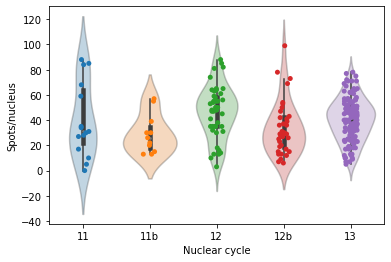

In [14]:
ax = sns.violinplot(x='cycle',y='numspots', data=data_, alpha=0.3);
plt.setp(ax.collections, alpha=.3);
sns.stripplot(x='cycle',y='numspots', data=data_);
ax.set(xlabel='Nuclear cycle', ylabel='Spots/nucleus')

In [123]:
mask = fm.make_dummy_mask(20, 200, 200, nuc_spacing=100)
sim = fm.simulate_blobs(mask, blob_radius_mean=0.5)

In [124]:
sim = fm.simulate_blobs(mask, blob_radius_mean=0.5, blob_number=200, bg_mean=10_000, bg_var=2600, blob_intensity_mean=30_000)
fm.viewer(sim, 6)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Greens', 'viridis', 'prism', '…

In [137]:
a = fm.make_scalespace_representation(sim, sigmas=[0.5,1,1.5,2,2.5,3,3.5,4])

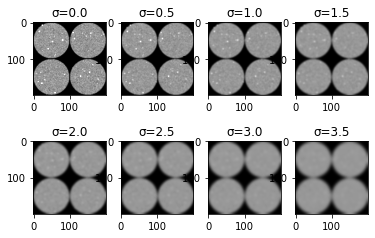

In [153]:
sim = fm.simulate_blobs(mask, blob_radius_mean=0.5, blob_number=200, bg_mean=10_000, bg_var=2600, blob_intensity_mean=30_000)
a = fm.make_scalespace_representation(sim, sigmas=[0.5,1,1.5,2,2.5,3,3.5,4])
fig, ax = plt.subplots(2,4)
axes = np.ravel(ax)
for i in range(0, 8):
    axes[i].imshow(a[i,0], cmap="gray", vmax=17000)
    axes[i].set_title('σ=' + str(i * 0.5))
#axes[7].imshow(np.zeros((4,4)))

In [147]:
sim = fm.simulate_blobs(mask, blob_radius_mean=2, blob_number=200, bg_mean=10_000, bg_var=2600, blob_intensity_mean=30_000)
fm.viewer(sim, 6)

interactive(children=(Dropdown(description='Color', index=4, options=('magma', 'Greens', 'viridis', 'prism', '…

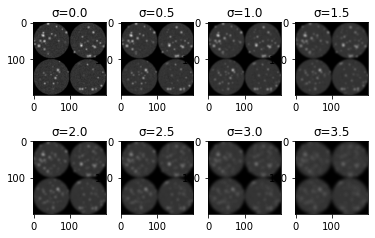

In [154]:
sim = fm.simulate_blobs(mask, blob_radius_mean=1.5, blob_number=200, bg_mean=10_000, bg_var=2600, blob_intensity_mean=30_000)
a = fm.make_scalespace_representation(sim, sigmas=[0.5,1,1.5,2,2.5,3,3.5,4])
fig, ax = plt.subplots(2,4)
axes = np.ravel(ax)
for i in range(0, 8):
    axes[i].imshow(a[i,0], cmap="gray", vmax=50000)
    axes[i].set_title('σ=' + str(i * 0.5))
#axes[7].imshow(np.zeros((4,4)))